In [1]:
# VAE, Variational AutoEncoder
# Step 1: VAE encoder network

import keras
from keras import models, layers
from keras import backend as K
import numpy as np

height = 28
width = 28
n_channels = 1
input_shape = (height, width, n_channels)

# Set a dimension that VAE model makes a 2D latent space.
latent_dim = 2

input_img = keras.Input(shape=input_shape)

x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(input_img)
x = layers.Conv2D(filters=64,
                  kernel_size=3,
                  padding='same',
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(filters=64,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.Conv2D(filters=64,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(units=32, activation='relu')(x)

# Suppose this model outputs the mean and log variance.
z_mean = layers.Dense(units=latent_dim)(x)
z_log_var = layers.Dense(units=latent_dim)(x)

Using TensorFlow backend.


In [2]:
# Step 2: Sampling latent space
def sampling(args):
    z_mean, z_log_var = args
    # Add small random elements.
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.0,
                              stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# Lambda layer, with sampling function, choose a sample point on latent space
# by following z_mean and z_log_var.
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [4]:
# Step 3: Decoder network

decoder_input = layers.Input(K.int_shape(z)[1:])

# (batch_size, 2) to shape before flattening in encoder network.
upsampling_factor = np.prod(shape_before_flattening[1:])
x = layers.Dense(units=upsampling_factor,
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)

# Using transposed convolution layer to upscale.
x = layers.Conv2DTranspose(filters=32,
                           kernel_size=3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
# Make a grey-scale image.
x = layers.Conv2D(filters=1,
                  kernel_size=3,
                  padding='same',
                  activation='sigmoid')(x)

decoder = models.Model(input=decoder_input, output=x)

z_decoded = decoder(z)

/home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [5]:
# Decoder network
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Inherit keras.layers.Layer class.
class VariationLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # xent is loss by calculating binary crossentropy.
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        '''
        Kullback–Leibler_divergence, loss is a measure of
        how one probability distribution is different from a second
        '''
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
                                 axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [7]:
# Final outputs of encoder-sampling-decoder network.
y = VariationLayer()([input_img, z_decoded])

In [8]:
# Decoder network outputs z_decoded, decoded image.
# VAE model has multiple inputs as decoded image and original image.

vae = models.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [9]:
from keras.datasets import mnist

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

In [10]:
# Preprocessing before input.

train_data = train_data.astype('float32') / 255.0
train_data = np.expand_dims(train_data, axis=-1)
test_data = test_data.astype('float32') / 255.0
test_data = np.expand_dims(test_data, axis=-1)

In [11]:
vae.fit(train_data, None,
        shuffle=True,
        epochs=10,
        batch_size=16,
        validation_data=(test_data, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 33s 547us/step - loss: 0.2143 - val_loss: 0.1989
Epoch 2/10
60000/60000 [==============================] - 31s 515us/step - loss: 0.1960 - val_loss: 0.1943
Epoch 3/10
60000/60000 [==============================] - 31s 512us/step - loss: 0.1915 - val_loss: 0.1895
Epoch 4/10
60000/60000 [==============================] - 31s 515us/step - loss: 0.1891 - val_loss: 0.1877
Epoch 5/10
60000/60000 [==============================] - 31s 517us/step - loss: 0.1876 - val_loss: 0.1864
Epoch 6/10
60000/60000 [==============================] - 31s 517us/step - loss: 0.1864 - val_loss: 0.1865
Epoch 7/10
60000/60000 [==============================] - 31s 518us/step - loss: 0.1855 - val_loss: 0.1851
Epoch 8/10
60000/60000 [==============================] - 31s 520us/step - loss: 0.1847 - val_loss: 0.1868
Epoch 9/10
60000/60000 [==============================] - 31s 524us/step - loss: 0.1841 - val_

In [13]:
vae.save('mnist_vae_model.h5')

In [34]:
# Decode sample points on latent space into decoded image
# by using a decoder network.

import matplotlib.pyplot as plt
from scipy.stats import norm
# Scipy statistics library, norm is normal distribution package.

# (15, 15) grids
n_grids = 15
batch_size = 16

grid = np.zeros((height*n_grids, width*n_grids))

# ppf is a inverse function of cdf, cumulative distribution function.
# (e.g) probability = cdf(X)
#       ppf(probability) = x
# norm.ppf make a x point of normal distribution coressponding to ratio.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n_grids))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n_grids))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample_batch = np.zeros((batch_size, 2)) + z_sample
        decoded_sample = decoder.predict(z_sample_batch,
                                         batch_size=batch_size)
        # Choose a first digit image.
        digit = decoded_sample[0].reshape(height, width)
        px = i*height
        py = j*width
        grid[px:px+height, py:py+width] = digit

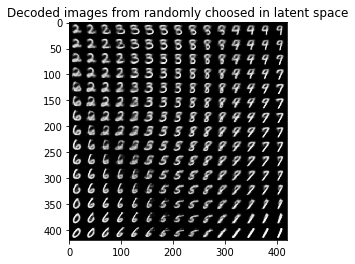

In [38]:
plt.figure('Decoded images from randomly choosed in latent space')
plt.title('Decoded images from randomly choosed in latent space')
# Color map is reverse grey-scale.
plt.imshow(grid, cmap='Greys_r')
plt.savefig('decoded_grid.png')
plt.show()

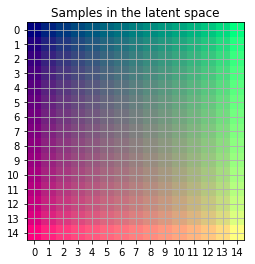

In [85]:
z_samples = np.zeros((n_grids, n_grids, 3))

for i, px in enumerate(grid_x):
    for j, py in enumerate(grid_y):
        z_samples[i,j, :2] = [px, py]

z_samples += np.abs(np.min(z_samples))
z_samples /= z_samples.max()
        
fig = plt.figure('Samples in the latent space')
plt.title('Samples in the latent space')
plt.imshow(z_samples, cmap='viridis')
plt.xticks(np.arange(n_grids))
plt.yticks(np.arange(n_grids))
plt.grid()
plt.show()